In this example, we consider the simplest two-level system. First, we define the system and plot the energy levels. Following that, a Rabi oscillation is simulated for two different excitation field vectors $\vec{B}_1(t)$ , with the results being fitted and plotted in the Bloch sphere. Lastly, we simulate a Hahn echo decay for a model collapse operator.

In [9]:
import numpy as np
from qutip import sigmax, sigmay, sigmaz, basis, fock_dm

from quaccatoo import QSys, PulsedSim, Analysis, RabiModel, Rabi, Hahn, square_pulse

# 1. Defining the Spin 1/2 System

We begin defining a general two-level system with a time independent Hamiltonian given by
$$ H_0 = \frac{\omega_0}{2} \sigma_z ,$$ 
where $\omega_0=1$ MHz is the energy difference between the two levels and $\sigma_z$ the Pauli matrix. Although simple, this Hamiltonian can represent a varied number of systems: from spin-1/2 nuclear spins in NMR, to electronic spins in EPR, to superconducting qubits. Let us assume now that the state is initialized in the state $|0 \rangle$ and we also consider that the system has an observable given by the operator $\sigma_z$.

In [10]:
w0 = 1

# create the QSys object with the desired parameters
qsys = QSys(
    H0 = w0/2 * sigmaz(),
    rho0 = basis(2, 0),
    observable = sigmaz(),
    # sets the Hamiltonian units. By default it is considered to be in frequency units.
    units_H0 = 'MHz'
)

The energy levels are trivial in this simple case. To visualize them we use the plot_energy method from quaccatoo. Note, that in QSys class, the lowest state energy is subtracted from all the eigenenergies to have the lowest level at 0.

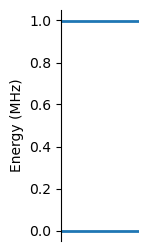

In [11]:
qsys.plot_energy(figsize=(1,3))

# 2. Rabi Oscillation

With the quantum system defined, the first measurement to perform is a Rabi oscillation. This is done by applying a resonant pulse to the system with varying length, such that it will drive the system between the two levels causing a period oscillation of the observable expectation value. Let us consider a square cosine pulse of frequency $\omega_0$ applied on the x-axis of the laboratory frame. The interaction of the pulse with the system is then described in terms of a control Hamiltonian given by
$$ H_1 = \omega_1 \sigma_x ,$$
which is then multiplied by the time-dependent pulse function. $\omega_1$ is the Rabi frequency, related to the amplitude of the pulse.

First, let's consider a rabi frequency 10 times smaller than the resonance frequency $\omega_1=\omega_0/10$, such that the rotating wave approximation is valid.

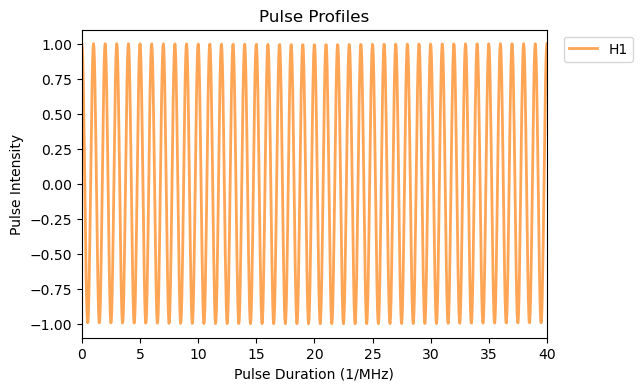

In [12]:
w1 = w0/10

# create the Rabi object for the qsys and the desired parameters
rabi_exp = Rabi(
    # time array of pulse duration which we want to simulate the experiment
    pulse_duration = np.linspace(0, 40, 1000), 
    # we pass the qsys object defined in the previous section
    system = qsys, 
    # the Hamiltonian for the interaction with the pulse
    H1 = w1*sigmax(), 
    # the pulse shape function we want to use (this line is redundant since square_pulse is the default pulse shape function if not specified)
    pulse_shape = square_pulse,
    # we need to pass the the frequency of the pulse as the resonant frequency of the system
    pulse_params = {'f_pulse': w0}, 
)

rabi_exp.plot_pulses()

To visualize the pulse sequence we can use the `plot_pulses method`, where we can see the pulse shape and the pulse duration. With the run method the experiment is simulated and the expectation value of the observable is plotted with plot_results.

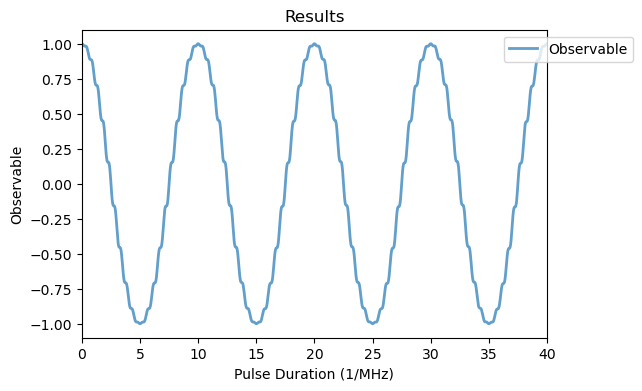

In [13]:
rabi_exp.run()

Analysis(rabi_exp).plot_results()

As expected, the expectation value of the operator shows a period oscillation, but with a small modulation related to the rotating wave approximation as we chose $\omega_0/\omega_1=10$. For larger ratios, this modulation disappears (check yourself!). Now to fit the data we use the `Analysis` class.

The `Analysis` instance provides the `run_fit` method which takes in a `fit_model` parameter (an `lmfit` model instance, and optionally also a `guess` parameter for the initial values). We can then visualize the fit via the `plot_fit` method. The `fit_params` attribute contains the detailed fitting report.

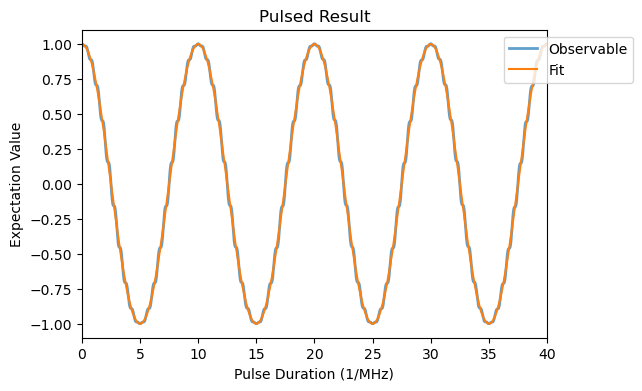

In [14]:
rabi_analysis = Analysis(rabi_exp)

rabi_analysis.run_fit(
    # here we use the RabiModel as a target for fitting
    fit_model = RabiModel(), 
    )

# plot the results and print the params of the fit
rabi_analysis.plot_fit()
rabi_analysis.fit_params

Here, we observe that the fitted value of the $\pi$-pulse duration $t_\pi \cong 5.001$ μs is slightly larger than the expected value of $1/(2 \omega_1) = 5$ μs. To obtain a more accurate value, we can consider a rotating pulse with two control Hamiltonians $\sigma_x$ and $\sigma_y$, for that we define custom pulse shape for X and Y with a dephasing of $\pi/2$ as follows.

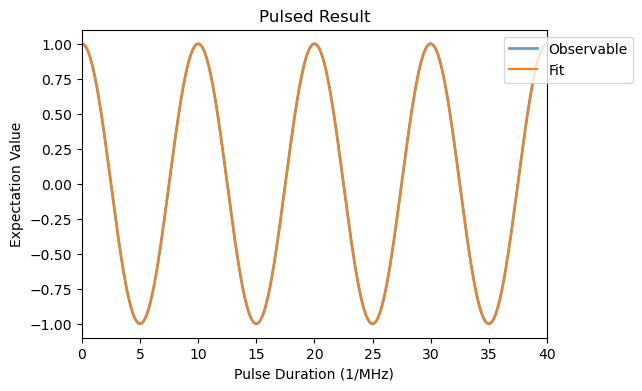

In [15]:
def custom_pulseX(t):
    return np.cos(w0*t)

def custom_pulseY(t):
    return np.cos(w0*t - np.pi/2)

rabi_exp_2 = Rabi(
    pulse_duration = np.linspace(0, 40, 1000),
    system = qsys,
    # the Hamiltonian for the interaction with the pulse now is a list with the two control Hamiltonians for X and Y
    H1 = [w1*sigmax()/2, w1*sigmay()/2], 
    # for the pulse_shape we pass a list with the two custom pulse shape functions, as now the custom pulses have no other parameters and pulse_params dictionary is empty
     pulse_shape = [custom_pulseX, custom_pulseY] 
)
   
rabi_exp_2.run()
rabi_analysis_2 = Analysis(rabi_exp_2)

# fit the Rabi oscillations with the run_fit method same as before
rabi_analysis_2.run_fit(
    fit_model = RabiModel(),
    )

rabi_analysis_2.plot_fit()
rabi_analysis_2.fit_params

In the rotating frame of reference, this new rotating pulse is fully aligned within the $x$-axis. Thus, the modulations have disappeared and the $t_\pi$ value is closer to the expected value of $1/(2\omega_1)$. Another useful way to visualize the Rabi oscillation is through the Bloch sphere representation with the `plot_bloch` method, as shown below. In the rotating frame, the Bloch vector rotates around the $x$-axis. However, in the laboratory frame, it rotates in a spiral.

ValueError: The included colors are not valid. colors must be equivalent to a 1D array with the same size as the number of states.

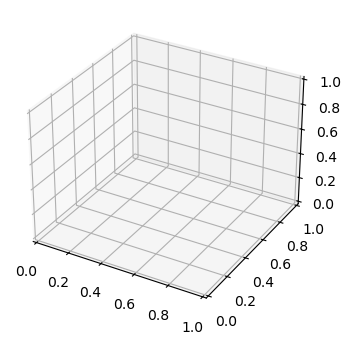

In [16]:
rabi_exp_3 = Rabi(
    # In this case we define a pulse duration array which goes up to a pi-pulse
    pulse_duration = np.linspace(0, 1/2/w1, 500), 
    system = qsys, 
    H1 = [w1*sigmax()/2, w1*sigmay()/2],
    pulse_shape = [custom_pulseX, custom_pulseY]
)

rabi_exp_3.run()
rabi_analysis_3 = Analysis(rabi_exp_3)

rabi_analysis_3.plot_bloch()

# 3. Hahn Echo

Another important quantity in quantum systems is the coherence time $T_2$, being a measure of how fast a system loses its quantum information, or in other words, how fast it becomes classical. To model the non-unitary process which causes quantum decoherence, we make use of the Lindblad master equation from Qutip. We define as collapse operator
$$ C = \gamma \sigma_z ,$$
where $\gamma=0.1$ MHz is rate of decoherence, inversely proportional to $T_2$. The Hahn echo sequence is then used to measure the coherence time, being composed of two free evolutions with a refocusing $\pi$-pulse in between. An initial and final $\pi/2$-pulses are also included in order to project the spin the quantization axis.

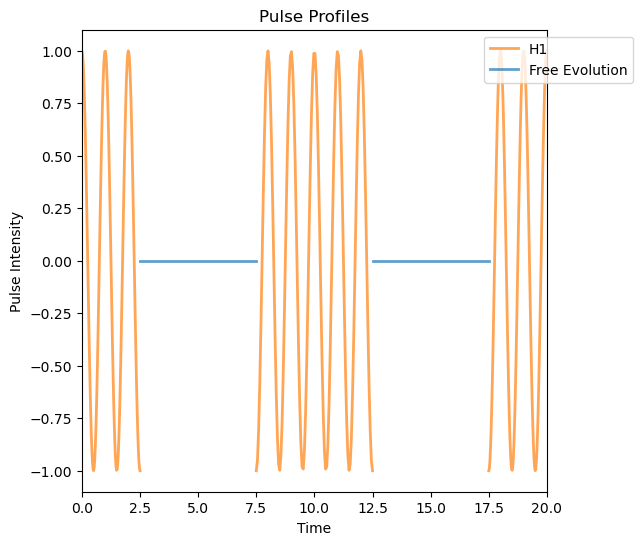

In [ ]:
gamma = 0.1

# overwrite the c_ops attribute of the QSys object
qsys.c_ops = gamma * sigmaz()

hahn_exp = Hahn(
    free_duration = np.linspace(5, 25, 30),
    pi_pulse_duration= 1/2/w1,
    # include the pi/2 pulse after the second free evolution (this line is redundant since it is the default value)    
    projection_pulse=True,
    system = qsys,
    H1 = w1*sigmax(), 
    pulse_shape=square_pulse,
    pulse_params = {'f_pulse': w0}
)

hahn_exp.plot_pulses(tau=10)

In this case, we can observe the initial and final $\pi/2$ pulses, the two free evolutions and the middle $\pi$-pulse. Finaly, running the experiment leads to an exponential decay of the observable expectation value, known as the Hahn echo decay.

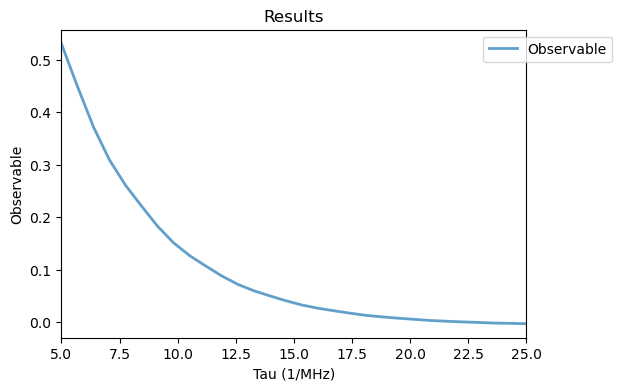

In [ ]:
hahn_exp.run()
Analysis(hahn_exp).plot_results()

## 3.1. Custom sequence

Let's say now that we want to end the Hahn echo sequence with $3\pi/2$ pulse instead of $\pi/2$. This sequence is not predefined in QuaCCAToo, but the user can define it as below. The custom sequence needs to be defined as a python function of a controlled variable, in this case of the free evolution time $\tau$, and a dictionary with the sequence arguments.

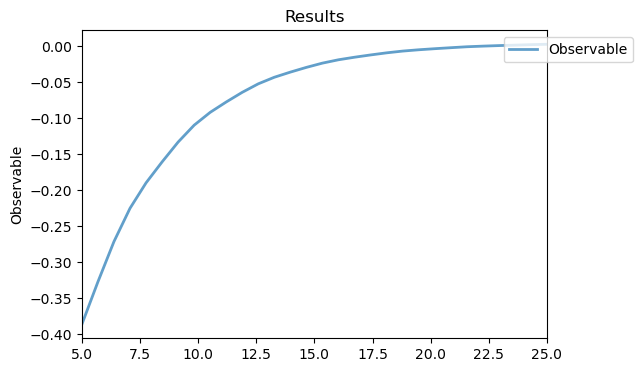

In [ ]:
def custom_Hahn(tau, **kwargs):

    # calculate pulse separation time !!! pulse separation time is tau - length of a pi-pulse !!!
    ps = tau - kwargs['t_pi'] 

    # we start initializing the sequence
    seq = PulsedSim(kwargs['qsys'])

    seq.add_pulse(duration=kwargs['t_pi']/2, H1=kwargs['H1'], pulse_shape=kwargs['pulse_shape'], pulse_params = {'f_pulse': kwargs['delta']})
    seq.add_free_evolution(duration=ps)
    seq.add_pulse(duration=kwargs['t_pi'], H1=kwargs['H1'], pulse_shape=kwargs['pulse_shape'], pulse_params = {'f_pulse': kwargs['delta']})
    seq.add_free_evolution(duration=ps)
    seq.add_pulse(duration=3*kwargs['t_pi']/2, H1=kwargs['H1'], pulse_shape=kwargs['pulse_shape'], pulse_params = {'f_pulse': kwargs['delta']})

    return seq.rho

# The sequence arguments are passed through a dictionary
sequence_kwargs = {
    'qsys': qsys,
    'H1': w1*sigmax(),
    'pulse_shape': square_pulse,
    'delta': w0,
    't_pi': 1/2/w1,
    'w1': w1 
}

custom_seq = PulsedSim(qsys)
# in this case the run method should be specified with the variable and sequence
custom_seq.run(variable=np.linspace(5, 25, 30), sequence=custom_Hahn, sequence_kwargs=sequence_kwargs)
Analysis(custom_seq).plot_results()

In this case thus, the expectation value start from negatives values then decays to 0 due to the final $3\pi/2$ pulse.